In [102]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from imblearn.over_sampling import SMOTE
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Input, Flatten
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('data\labeled.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6903 entries, 0 to 6902
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sentence_id  6903 non-null   object 
 1   review_id    6903 non-null   float64
 2   review       6903 non-null   object 
 3   word_count   6903 non-null   int64  
 4   vader        6903 non-null   int64  
 5   textblob     6903 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 323.7+ KB


In [6]:
df['vader'].value_counts()

1    6163
0     740
Name: vader, dtype: int64

In [7]:
df['textblob'].value_counts()

1    5957
0     946
Name: textblob, dtype: int64

# Transform

In [10]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 25
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5213 unique tokens.


In [12]:
X = tokenizer.texts_to_sequences(df['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (6903, 25)


In [45]:
Y_vader = df[['vader']].values
print('Shape of label tensor:', Y_vader.shape)

Shape of label tensor: (6903, 1)


In [43]:
Y_textblob = df[['textblob']].values
print('Shape of label tensor:', Y_textblob.shape)

Shape of label tensor: (6903, 1)


In [46]:
# Train test split vader
X_vader_train, X_vader_test, Y_vader_train, Y_vader_test = train_test_split(X,Y_vader, test_size = 0.3, random_state = 42)
print(X_vader_train.shape,Y_vader_train.shape)

(4832, 25) (4832, 1)


In [47]:
# Train test split textblob
X_textblob_train, X_textblob_test, Y_textblob_train, Y_textblob_test = train_test_split(X,Y_textblob, test_size = 0.3, random_state = 42)
print(X_textblob_train.shape,Y_textblob_train.shape)

(4832, 25) (4832, 1)


# Resampling

In [48]:
# Oversampling vader
sm = SMOTE(random_state=42)
X_vader_train_res, Y_vader_train_res = sm.fit_resample(X_vader_train, Y_vader_train)
print(X_vader_train_res.shape,Y_vader_train_res.shape)

(8636, 25) (8636,)


In [49]:
# Oversampling textblob
sm = SMOTE(random_state=42)
X_textblob_train_res, Y_textblob_train_res = sm.fit_resample(X_textblob_train, Y_textblob_train)
print(X_textblob_train_res.shape,Y_textblob_train_res.shape)


(8370, 25) (8370,)


# Modeling

## LSTM

In [84]:
max_features = 5000
embed_dim = 128
lstm_vader = Sequential()
lstm_vader.add(Input(shape=[MAX_SEQUENCE_LENGTH], name='input'))
lstm_vader.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
lstm_vader.add(LSTM(100, dropout=0.2,return_sequences=True))
lstm_vader.add(Dropout(0.2))
lstm_vader.add(LSTM(50,dropout=0.2,  return_sequences=True))
lstm_vader.add(Dropout(0.2))
lstm_vader.add(Flatten())
lstm_vader.add(Dense(1, activation='softmax'))
lstm_vader.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_vader.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 25, 100)           5000000   
                                                                 
 lstm_10 (LSTM)              (None, 25, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 25, 100)           0         
                                                                 
 lstm_11 (LSTM)              (None, 25, 50)            30200     
                                                                 
 dropout_3 (Dropout)         (None, 25, 50)            0         
                                                                 
 flatten_1 (Flatten)         (None, 1250)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                

In [89]:
lstm_textblob = lstm_vader
lstm_textblob.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(lstm_textblob.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 25, 100)           5000000   
                                                                 
 lstm_10 (LSTM)              (None, 25, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 25, 100)           0         
                                                                 
 lstm_11 (LSTM)              (None, 25, 50)            30200     
                                                                 
 dropout_3 (Dropout)         (None, 25, 50)            0         
                                                                 
 flatten_1 (Flatten)         (None, 1250)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                

## Train with VADER dataset

In [86]:
epoches = 10
batch_size = 64
vader_history = lstm_vader.fit(X_vader_train_res, Y_vader_train_res, 
                          epochs=epoches, batch_size=batch_size,validation_split=0.2,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
108/108 [==============================] - 12s 110ms/step - loss: 0.4495 - accuracy: 0.6251 - val_loss: 0.9682 - val_accuracy: 0.0000e+00
Epoch 2/10
108/108 [==============================] - 14s 128ms/step - loss: 0.3542 - accuracy: 0.6251 - val_loss: 1.0572 - val_accuracy: 0.0000e+00
Epoch 3/10
108/108 [==============================] - 15s 141ms/step - loss: 0.2823 - accuracy: 0.6251 - val_loss: 1.0529 - val_accuracy: 0.0000e+00
Epoch 4/10
108/108 [==============================] - 15s 139ms/step - loss: 0.2316 - accuracy: 0.6251 - val_loss: 1.3814 - val_accuracy: 0.0000e+00


In [95]:
#valuation
accr = lstm_vader.evaluate(X_vader_test,Y_vader_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

65/65 [==============================] - 1s 8ms/step - loss: 1.6641 - accuracy: 0.8909
Test set
  Loss: 1.664
  Accuracy: 0.891


In [99]:
#print classification report
y_pred = lstm_vader.predict(X_vader_test)
print('Classification Report')
print(classification_report(Y_vader_test, y_pred))

65/65 [==============================] - 1s 10ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       226
           1       0.89      1.00      0.94      1845

    accuracy                           0.89      2071
   macro avg       0.45      0.50      0.47      2071
weighted avg       0.79      0.89      0.84      2071



C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: U

In [104]:
# confusion matrix
print(confusion_matrix(Y_vader_test, y_pred))

[[   0  226]
 [   0 1845]]


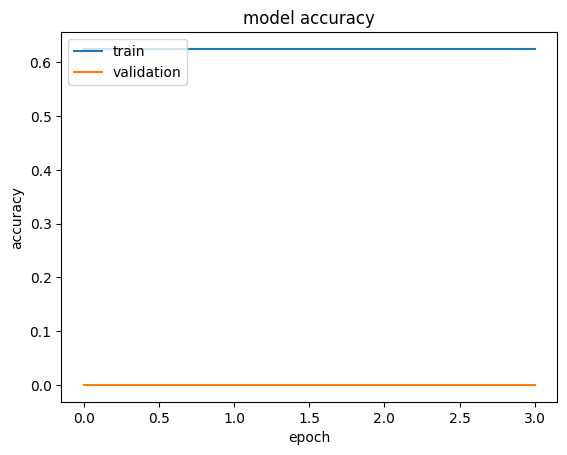

In [88]:
plt.plot(vader_history.history['accuracy'])
plt.plot(vader_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
#this plot is to determine the appropriate epoches

## Train with TextBlob dataset

In [90]:
epoches = 4
batch_size = 64
textblob_history = lstm_textblob.fit(X_textblob_train_res, Y_textblob_train_res,
                                epochs=epoches, batch_size=batch_size,validation_split=0.2,
                                callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/4
105/105 [==============================] - 18s 128ms/step - loss: 0.5247 - accuracy: 0.6250 - val_loss: 0.7210 - val_accuracy: 0.0000e+00
Epoch 2/4
105/105 [==============================] - 13s 121ms/step - loss: 0.3958 - accuracy: 0.6250 - val_loss: 0.4314 - val_accuracy: 0.0000e+00
Epoch 3/4
105/105 [==============================] - 16s 149ms/step - loss: 0.3050 - accuracy: 0.6250 - val_loss: 0.6868 - val_accuracy: 0.0000e+00
Epoch 4/4
105/105 [==============================] - 16s 154ms/step - loss: 0.2374 - accuracy: 0.6250 - val_loss: 0.6908 - val_accuracy: 0.0000e+00


In [91]:
accr = lstm_textblob.evaluate(X_textblob_test,Y_textblob_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

65/65 [==============================] - 2s 10ms/step - loss: 2.2016 - accuracy: 0.8556
Test set
  Loss: 2.202
  Accuracy: 0.856


In [101]:
#print classification report
y_pred = lstm_textblob.predict(X_textblob_test)
print('Classification Report')
print(classification_report(Y_textblob_test, y_pred))

65/65 [==============================] - 1s 8ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       299
           1       0.86      1.00      0.92      1772

    accuracy                           0.86      2071
   macro avg       0.43      0.50      0.46      2071
weighted avg       0.73      0.86      0.79      2071



C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: U

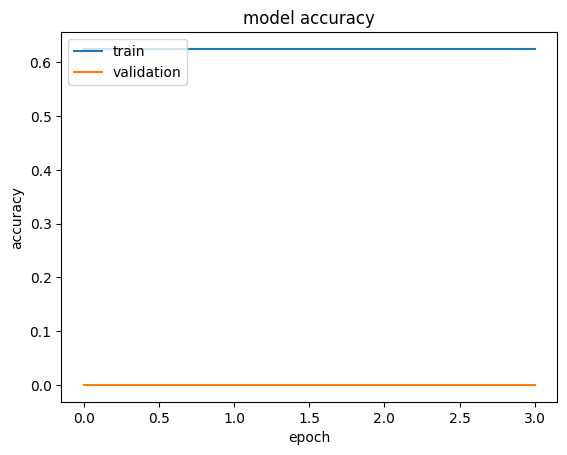

In [92]:
plt.plot(textblob_history.history['accuracy'])
plt.plot(textblob_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')